In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функицию.

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [7]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [9]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [10]:
import matplotlib.pyplot as plt

In [11]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

## AdaBoost

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer

In [13]:
X, y = load_breast_cancer(return_X_y=True)

Разделим выборку на обучающую и тестовую

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Реализуем функцию подсчета ошибки

In [15]:
def get_error(pred, y):
    return sum(pred != y) / len(y)

И сам алгоритм

In [16]:
def adaboost(X, y, N, max_depth=1):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        clf = DecisionTreeClassifier(max_depth=max_depth)
        clf.fit(X, y, sample_weight=w)

        predictions = clf.predict(X)
        e = get_error(predictions, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1 - 1/n_classes: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[~match] *= np.exp(alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

Обучим алгоритм из 50 деревьев

In [17]:
N = 50

models = adaboost(X_train, y_train, N)

Теперь осуществим предсказание

In [18]:
def predict(X, models):
    n_classes = 2
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred[range(n_objects), prediction] += alpha
    
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

In [19]:
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))

#### График зависимости точности от кол-ва деревьев в ансамбле

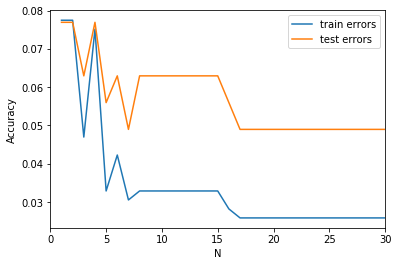

In [20]:
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend(loc='upper right');

In [30]:
train_errors = []
test_errors = []

for n in range(1, 12):
    mods = adaboost(X_train, y_train, 14, n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))

/home/yzi/projects/gb_algorithms/env/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/home/yzi/projects/gb_algorithms/env/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/home/yzi/projects/gb_algorithms/env/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/home/yzi/projects/gb_algorithms/env/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/home/yzi/projects/gb_algorithms/env/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/home/yzi/projects/gb_algorithms/env/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/home/yzi/projects/gb_algorithms/env/lib/python3.6/site-packages/ipykernel_launcher.py:2

/home/yzi/projects/gb_algorithms/env/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/home/yzi/projects/gb_algorithms/env/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/home/yzi/projects/gb_algorithms/env/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/home/yzi/projects/gb_algorithms/env/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/home/yzi/projects/gb_algorithms/env/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/home/yzi/projects/gb_algorithms/env/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/home/yzi/projects/gb_algorithms/env/lib/python3.6/site-packages/ipykernel_launcher.py:2

<a id="hw"></a>

#### График зависимости точности от глубины деревьев

сильное переобучение

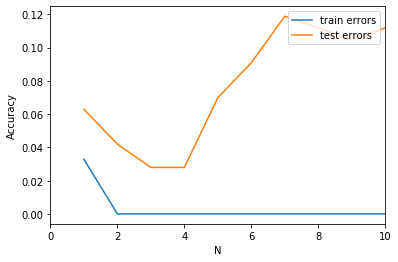

In [32]:
x = list(range(1, 12))

plt.xlim(0, 10)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend(loc='upper right');